In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Model

import tensorflow as tf
from keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pylab as plt
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import os
import numpy as np

In [2]:
data_dir=r"dataset\valid"
skin=[]
for file in os.listdir(data_dir):
    skin+=[file]
print(skin)
print(len(skin))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
7


In [3]:
datagen = ImageDataGenerator(rescale = 1./255)
train_data = datagen.flow_from_directory("dataset/Train/", target_size = (224,224), batch_size = 15, class_mode = 'categorical')
test_data = datagen.flow_from_directory("dataset/valid/", target_size = (224,224), batch_size = 15, class_mode = 'categorical')

Found 8512 images belonging to 7 classes.
Found 1503 images belonging to 7 classes.


In [9]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [10]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [11]:
vgg = VGG16(input_shape=(224,224, 3), include_top=False,weights = 'imagenet')

In [12]:
for layers in (vgg.layers):
    layers.trainable = False

In [20]:
model = Sequential()

model.add(vgg)
# Add new layers
model.add(Flatten())
model.add(Dense(512 , activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.summary()
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['accuracy',precision,recall,sensitivity,specificity])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 27,563,847
Trainable params: 12,849,159
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
mcp = ModelCheckpoint('NEW models/Vgg16.h5', verbose=1)
es=EarlyStopping(monitor='val_loss', patience = 10)

In [22]:
train_steps = train_data.n // train_data.batch_size
test_steps = test_data.n // test_data.batch_size

In [23]:
history = model.fit(train_data,steps_per_epoch=train_steps,epochs=30,validation_data=test_data,validation_steps=test_steps,verbose=1,callbacks=[mcp,es])

Epoch 1/30
567/567 [==============================] - ETA: 0s - loss: 1.0283 - accuracy: 0.6746 - precision: 0.7848 - recall: 0.6017 - sensitivity_at_specificity: 0.9892 - specificity_at_sensitivity: 0.9986
Epoch 1: saving model to NEW models\Vgg16.h5
567/567 [==============================] - 2293s 4s/step - loss: 1.0283 - accuracy: 0.6746 - precision: 0.7848 - recall: 0.6017 - sensitivity_at_specificity: 0.9892 - specificity_at_sensitivity: 0.9986 - val_loss: 0.8888 - val_accuracy: 0.7020 - val_precision: 0.8243 - val_recall: 0.5973 - val_sensitivity_at_specificity: 0.9940 - val_specificity_at_sensitivity: 0.9993
Epoch 2/30
567/567 [==============================] - ETA: 0s - loss: 0.9263 - accuracy: 0.6892 - precision: 0.8041 - recall: 0.6056 - sensitivity_at_specificity: 0.9879 - specificity_at_sensitivity: 0.9989
Epoch 2: saving model to NEW models\Vgg16.h5
567/567 [==============================] - 2253s 4s/step - loss: 0.9263 - accuracy: 0.6892 - precision: 0.8041 - recall: 0.60

567/567 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.7664 - precision: 0.8394 - recall: 0.6818 - sensitivity_at_specificity: 0.9919 - specificity_at_sensitivity: 0.9996
Epoch 14: saving model to NEW models\Vgg16.h5
567/567 [==============================] - 2283s 4s/step - loss: 0.6819 - accuracy: 0.7664 - precision: 0.8394 - recall: 0.6818 - sensitivity_at_specificity: 0.9919 - specificity_at_sensitivity: 0.9996 - val_loss: 0.8288 - val_accuracy: 0.7387 - val_precision: 0.8120 - val_recall: 0.6740 - val_sensitivity_at_specificity: 0.9780 - val_specificity_at_sensitivity: 0.9990
Epoch 15/30
567/567 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.7765 - precision: 0.8502 - recall: 0.6945 - sensitivity_at_specificity: 0.9924 - specificity_at_sensitivity: 0.9997
Epoch 15: saving model to NEW models\Vgg16.h5
567/567 [==============================] - 2374s 4s/step - loss: 0.6607 - accuracy: 0.7765 - precision: 0.8502 - recall: 0.6945 - sen

567/567 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.8123 - precision: 0.8694 - recall: 0.7536 - sensitivity_at_specificity: 0.9932 - specificity_at_sensitivity: 0.9996
Epoch 27: saving model to NEW models\Vgg16.h5
567/567 [==============================] - 2227s 4s/step - loss: 0.5456 - accuracy: 0.8123 - precision: 0.8694 - recall: 0.7536 - sensitivity_at_specificity: 0.9932 - specificity_at_sensitivity: 0.9996 - val_loss: 0.8267 - val_accuracy: 0.7587 - val_precision: 0.8148 - val_recall: 0.7040 - val_sensitivity_at_specificity: 0.9793 - val_specificity_at_sensitivity: 0.9989


In [24]:
model.save("NEW models/Vgg16.h5")

In [26]:
model.evaluate(test_data, verbose=1, steps=test_steps)

100/100 [==============================] - 333s 3s/step - loss: 0.8263 - accuracy: 0.7587 - precision: 0.8150 - recall: 0.7047 - sensitivity_at_specificity: 0.9793 - specificity_at_sensitivity: 0.9989


[0.8262560963630676,
 0.7586666941642761,
 0.8149576187133789,
 0.7046666741371155,
 0.9793333411216736,
 0.9988889098167419]

In [27]:
filenames = test_data.filenames 
nb_samples = len(filenames)
model_predict = model.predict(test_data,steps = nb_samples, verbose=2)

1503/1503 - 320s - 320s/epoch - 213ms/step


Confusion matrix, without normalization
[[  0   4   3   0   6  36   0]
 [  4   3   6   0   7  56   1]
 [  5  12  15   0  12 120   1]
 [  1   0   1   0   2  13   0]
 [  5  10  13   0  20 118   1]
 [ 34  64  73   2 102 726   5]
 [  0   2   0   0   2  18   0]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

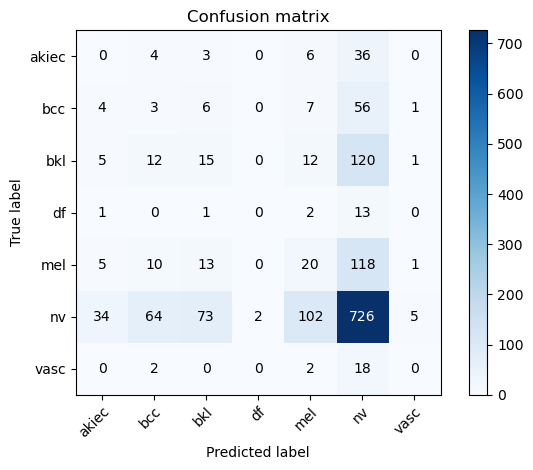

In [28]:
y_true = test_data.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['akiec','bcc','bkl','df','mel','nv','vasc'],
                      title='Confusion matrix')

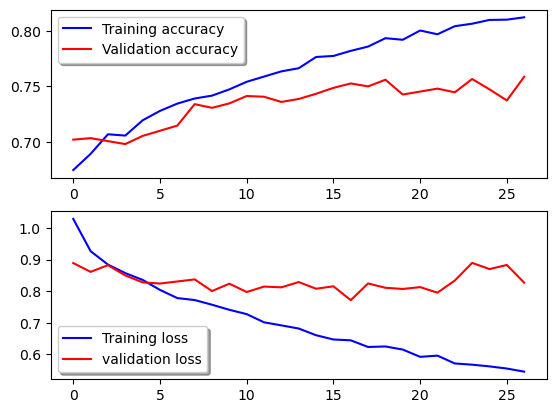

In [29]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)